<a href="https://colab.research.google.com/github/pat-nb/gun-detection-segmentation/blob/main/project1_gun_detection_segmentation_ChotirosS_PatB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Gun Detection & Segmentation

Course: AASD4015 - Advanced Applied Mathematical Concepts for Deep Learning

*   Chotiros Srisiam, #101411914
*   Pat Boonprasertsri, #101410612

## Dataset

[Kaggle - Weapons - Gun Detection & Segmentation](https://www.kaggle.com/datasets/trainingdatapro/people-with-guns-segmentation-and-detection/data)

## Install necessary packages

In [ ]:
!pip install xmltodict segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Import necessary libraries

In [14]:
import json, os, torch, cv2, xmltodict, numpy as np, albumentations as A
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from glob import glob
from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import time

## Set up environment

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Unzip dataset file

In [5]:
!unzip gun_segmentation.zip

Archive:  gun_segmentation.zip
  inflating: annotations.xml         
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpeg          
  inflating: images/2.jpg            
  inflating: images/3.jpg            
  inflating: images/4.jpg            
  inflating: images/5.jpg            
  inflating: images/6.jpg            
  inflating: images/7.jpg            
  inflating: images/8.jpg            
  inflating: images/9.jpeg           
  inflating: labels/0.png            
  inflating: labels/1.png            
  inflating: labels/10.png           
  inflating: labels/2.png            
  inflating: labels/3.png            
  inflating: labels/4.png            
  inflating: labels/5.png            
  inflating: labels/6.png            
  inflating: labels/7.png            
  inflating: labels/8.png            
  inflating: labels/9.png            
  inflating: people_with_guns.csv    


## Preprocessing

### Creating Custom Segmentation Dataset class

In [7]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, root, transformations = None):
        # Parsing XML annotations
        annotations = glob(f"{root}/annotations.xml")[0]
        self.annotations = xmltodict.parse(open(f"{annotations}","r").read())
        self.transformations, self.n_cls = transformations, 2

        # Processing annotations
        self.meta_data = {}
        for idx, annotation in enumerate(self.annotations["annotations"]["image"]):
            polygons = []
            fname = f"{root}{annotation['@name']}"
            if isinstance(annotation["polygon"], dict):
                if annotation["polygon"]["@label"] == "gun":
                    polygons.append(annotation["polygon"]["@points"])
            elif isinstance(annotation["polygon"], list):
                for index in range(len(annotation["polygon"])):
                    if annotation["polygon"][index]["@label"] == "gun":
                        polygons.append(annotation["polygon"][index]["@points"])
            self.meta_data[fname] = polygons

    # Length of dataset
    def __len__(self): return len(self.meta_data)

    # Get item function
    def __getitem__(self, idx):
        # Get image name
        im_name = list(self.meta_data.keys())[idx]
        # Read image
        im = cv2.cvtColor(cv2.imread(im_name), cv2.COLOR_BGR2RGB)[:, :, :3]
        gts = Image.new('L', (im.shape[1], im.shape[0]), 0)

        # Processing annotations
        for index, points in enumerate(self.meta_data[im_name]):

            annot_points = [point.split(",") for point in points.split(";")]

            points = [(round(float(point[0])), round(float(point[1]))) for point in annot_points]

            # Create a mask image
            maskIm = Image.new('L', (im.shape[1], im.shape[0]), 0)
            ImageDraw.Draw(maskIm).polygon(points, outline=1, fill=1)

            # Convert to numpy array
            gts += np.array(maskIm)

        # Apply transformations if provided
        if self.transformations:
            im, gts = self.apply_transformations(im, gts)

        return im, gts

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path, gt_path)

    def read_im(self, im_path, gt_path): return np.array(Image.open(im_path).convert("RGB")), np.array(Image.open(gt_path).convert("L"))

    # Function to apply transformations
    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]


### Define get data loaders function

In [8]:
def get_dls(root, transformations, bs, split = [0.6, 0.2, 0.2], ns = 4):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls

### Setting up variables

In [9]:
root = "/content/"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 2)


There are 6 number of images in the train set
There are 2 number of images in the validation set
There are 3 number of images in the test set



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Importing necessary packages for visualization and training

In [10]:
import random
from torchvision import transforms as tfs
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.nn import functional as F

## Training Model

In [11]:
model = smp.Unet(classes=n_cls)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.7MB/s]


## Define train function

In [12]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):
    # Function to measure metrics
    class Metrics():
        # Functions to calculate metrics
        def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

            self.pred, self.gt = torch.argmax(pred, dim = 1), gt.squeeze(1) # (batch, width, height)
            self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

        def to_contiguous(self, inp): return inp.contiguous().view(-1)

        def PA(self):

            with torch.no_grad():
                match = torch.eq(self.pred, self.gt).int()

            return float(match.sum()) / float(match.numel())

        def mIoU(self):

            with torch.no_grad():

                pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

                iou_per_class = []

                for c in range(self.n_cls):

                    match_pred = pred == c
                    match_gt   = gt == c

                    if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                    else:

                        intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                        union = torch.logical_or(match_pred, match_gt).sum().float().item()

                        iou = (intersect + self.eps) / (union + self.eps)
                        iou_per_class.append(iou)

                return np.nanmean(iou_per_class)

        def loss(self): return self.loss_fn(self.pred_, self.gt.long())

    # Function to measure time
    def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

    # Training process
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 8
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:
            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}


## Train model and obtain history

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 40, save_prefix = "guns")

Start training process...
Epoch 1 train process is started...


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Epoch 1 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 2.696 secs
Train Loss         -> 0.939
Train PA           -> 0.357
Train IoU          -> 0.192
Validation Loss    -> 1.189
Validation PA      -> 0.052
Validation IoU     -> 0.027

Loss decreased from inf to 1.189!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Epoch 2 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 1.753 secs
Train Loss         -> 0.776
Train PA           -> 0.495
Train IoU          -> 0.271
Validation Loss    -> 1.747
Validation PA      -> 0.121
Validation IoU     -> 0.062

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Epoch 3 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 2.013 secs
Train Loss         -> 0.663
Train PA           -> 0.620
Train IoU          -> 0.344
Validation Loss    -> 1.562
Validation PA      -> 0.218
Validation IoU     -> 0.113

Loss decreased from 1.747 to 1.562!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 4 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 1.891 secs
Train Loss         -> 0.574
Train PA           -> 0.741
Train IoU          -> 0.421
Validation Loss    -> 0.899
Validation PA      -> 0.404
Validation IoU     -> 0.210

Loss decreased from 1.562 to 0.899!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Epoch 5 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 1.588 secs
Train Loss         -> 0.520
Train PA           -> 0.813
Train IoU          -> 0.475
Validation Loss    -> 0.751
Validation PA      -> 0.527
Validation IoU     -> 0.275

Loss decreased from 0.899 to 0.751!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Epoch 6 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 1.584 secs
Train Loss         -> 0.444
Train PA           -> 0.901
Train IoU          -> 0.558
Validation Loss    -> 0.622
Validation PA      -> 0.665
Validation IoU     -> 0.352

Loss decreased from 0.751 to 0.622!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.88it/s]


Epoch 7 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 1.533 secs
Train Loss         -> 0.396
Train PA           -> 0.928
Train IoU          -> 0.580
Validation Loss    -> 0.503
Validation PA      -> 0.815
Validation IoU     -> 0.443

Loss decreased from 0.622 to 0.503!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Epoch 8 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 1.592 secs
Train Loss         -> 0.347
Train PA           -> 0.938
Train IoU          -> 0.610
Validation Loss    -> 0.401
Validation PA      -> 0.918
Validation IoU     -> 0.508

Loss decreased from 0.503 to 0.401!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Epoch 9 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 1.598 secs
Train Loss         -> 0.322
Train PA           -> 0.942
Train IoU          -> 0.625
Validation Loss    -> 0.333
Validation PA      -> 0.954
Validation IoU     -> 0.541

Loss decreased from 0.401 to 0.333!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


Epoch 10 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 2.085 secs
Train Loss         -> 0.286
Train PA           -> 0.955
Train IoU          -> 0.653
Validation Loss    -> 0.281
Validation PA      -> 0.975
Validation IoU     -> 0.573

Loss decreased from 0.333 to 0.281!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch 11 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 1.704 secs
Train Loss         -> 0.256
Train PA           -> 0.966
Train IoU          -> 0.697
Validation Loss    -> 0.239
Validation PA      -> 0.983
Validation IoU     -> 0.578

Loss decreased from 0.281 to 0.239!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


Epoch 12 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 1.574 secs
Train Loss         -> 0.243
Train PA           -> 0.962
Train IoU          -> 0.669
Validation Loss    -> 0.213
Validation PA      -> 0.985
Validation IoU     -> 0.550

Loss decreased from 0.239 to 0.213!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


Epoch 13 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 1.584 secs
Train Loss         -> 0.227
Train PA           -> 0.968
Train IoU          -> 0.710
Validation Loss    -> 0.205
Validation PA      -> 0.983
Validation IoU     -> 0.639

Loss decreased from 0.213 to 0.205!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


Epoch 14 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 1.575 secs
Train Loss         -> 0.209
Train PA           -> 0.969
Train IoU          -> 0.720
Validation Loss    -> 0.190
Validation PA      -> 0.985
Validation IoU     -> 0.576

Loss decreased from 0.205 to 0.190!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Epoch 15 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 1.682 secs
Train Loss         -> 0.198
Train PA           -> 0.971
Train IoU          -> 0.727
Validation Loss    -> 0.178
Validation PA      -> 0.984
Validation IoU     -> 0.509

Loss decreased from 0.190 to 0.178!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Epoch 16 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 1.611 secs
Train Loss         -> 0.186
Train PA           -> 0.975
Train IoU          -> 0.761
Validation Loss    -> 0.175
Validation PA      -> 0.981
Validation IoU     -> 0.655

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 17 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 2.386 secs
Train Loss         -> 0.177
Train PA           -> 0.974
Train IoU          -> 0.755
Validation Loss    -> 0.165
Validation PA      -> 0.982
Validation IoU     -> 0.663

Loss decreased from 0.175 to 0.165!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Epoch 18 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 1.671 secs
Train Loss         -> 0.165
Train PA           -> 0.976
Train IoU          -> 0.764
Validation Loss    -> 0.153
Validation PA      -> 0.984
Validation IoU     -> 0.664

Loss decreased from 0.165 to 0.153!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Epoch 19 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 1.591 secs
Train Loss         -> 0.163
Train PA           -> 0.974
Train IoU          -> 0.756
Validation Loss    -> 0.151
Validation PA      -> 0.980
Validation IoU     -> 0.682

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Epoch 20 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 1.576 secs
Train Loss         -> 0.152
Train PA           -> 0.977
Train IoU          -> 0.783
Validation Loss    -> 0.158
Validation PA      -> 0.974
Validation IoU     -> 0.658

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Epoch 21 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 1.557 secs
Train Loss         -> 0.150
Train PA           -> 0.974
Train IoU          -> 0.751
Validation Loss    -> 0.143
Validation PA      -> 0.979
Validation IoU     -> 0.670

Loss decreased from 0.158 to 0.143!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Epoch 22 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 1.688 secs
Train Loss         -> 0.142
Train PA           -> 0.977
Train IoU          -> 0.763
Validation Loss    -> 0.128
Validation PA      -> 0.984
Validation IoU     -> 0.690

Loss decreased from 0.143 to 0.128!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Epoch 23 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 23 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process results: 

Train Time         -> 1.682 secs
Train Loss         -> 0.135
Train PA           -> 0.978
Train IoU          -> 0.772
Validation Loss    -> 0.119
Validation PA      -> 0.988
Validation IoU     -> 0.728

Loss decreased from 0.128 to 0.119!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process is started...


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 24 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Epoch 24 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process results: 

Train Time         -> 2.234 secs
Train Loss         -> 0.127
Train PA           -> 0.981
Train IoU          -> 0.811
Validation Loss    -> 0.116
Validation PA      -> 0.987
Validation IoU     -> 0.717

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


Epoch 25 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 25 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process results: 

Train Time         -> 1.574 secs
Train Loss         -> 0.119
Train PA           -> 0.984
Train IoU          -> 0.832
Validation Loss    -> 0.111
Validation PA      -> 0.987
Validation IoU     -> 0.717

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Epoch 26 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 26 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process results: 

Train Time         -> 1.648 secs
Train Loss         -> 0.114
Train PA           -> 0.985
Train IoU          -> 0.844
Validation Loss    -> 0.108
Validation PA      -> 0.987
Validation IoU     -> 0.723

Loss did not decrease for 7 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Epoch 27 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 27 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process results: 

Train Time         -> 1.619 secs
Train Loss         -> 0.110
Train PA           -> 0.986
Train IoU          -> 0.846
Validation Loss    -> 0.102
Validation PA      -> 0.987
Validation IoU     -> 0.700

Loss decreased from 0.108 to 0.102!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process is started...


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Epoch 28 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Epoch 28 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process results: 

Train Time         -> 1.602 secs
Train Loss         -> 0.105
Train PA           -> 0.986
Train IoU          -> 0.851
Validation Loss    -> 0.098
Validation PA      -> 0.988
Validation IoU     -> 0.685

Loss did not decrease for 8 epoch(s)!
Stopping training process becuase loss value did not decrease for 8 epochs!
Train process is completed in 0.865 minutes.


## Plot class for visualization

In [16]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

## Plot the training history

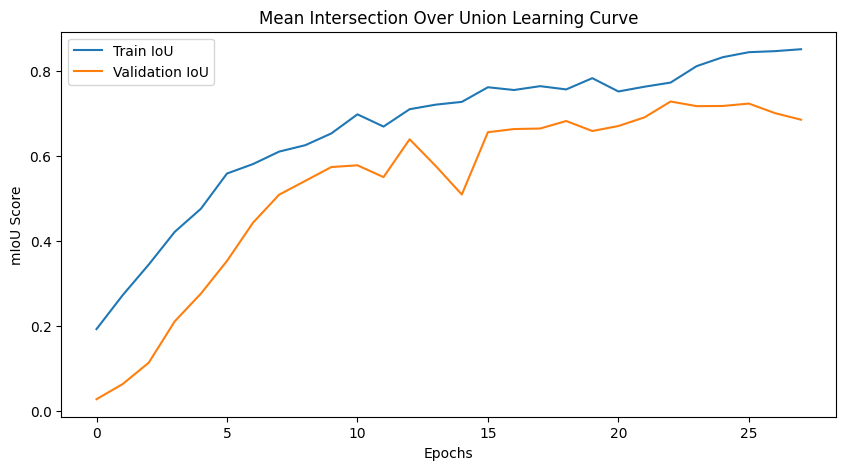

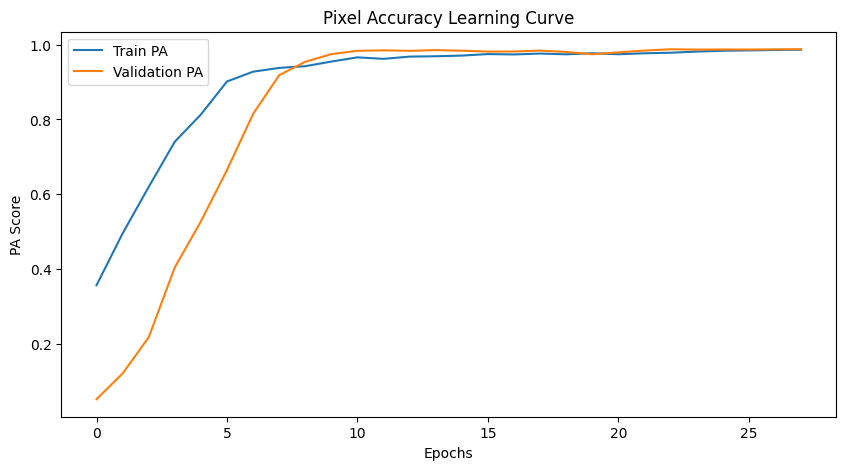

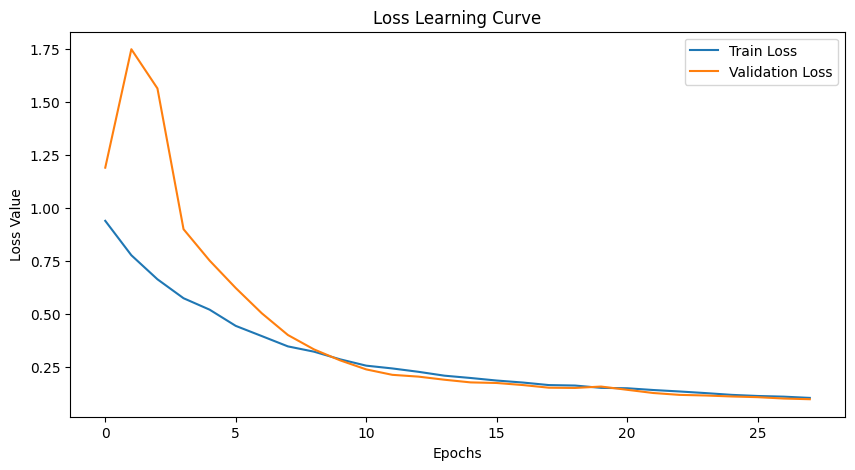

In [17]:
Plot(history)

***Mean Intersection Over Union (mIoU) Learning Curve:***

*   Both the Training IoU and Validation IoU show an increasing trend over epochs, indicating that the model is learning and improving its ability to accurately predict object boundaries.
*   The small gap between Training IoU and Validation IoU suggests that the model generalizes well to unseen data, as it performs similarly on both the training and validation datasets.

***Pixel Accuracy Learning Curve:***

*   Training Pixel Accuracy (Train PA) initially increases sharply but then plateaus, indicating that the model quickly learns to classify pixels correctly during the initial training epochs.
*   Validation Pixel Accuracy (Validation PA) also increases steadily but at a slower rate, suggesting that the model continues to improve its pixel-level classification performance on unseen validation data.
*   The increasing gap between Train PA and Validation PA implies a potential overfitting issue, where the model may be fitting too closely to the training data and not generalizing well to unseen data.

***Loss Learning Curve:***

*   Both Training Loss and Validation Loss decrease over epochs, indicating that the model is effectively minimizing its prediction errors during training and validation.
*   However, Training Loss decreases more rapidly than Validation Loss, indicating a potential overfitting problem.
*   This discrepancy suggests that the model is becoming too tailored to the training data, leading to poorer performance on unseen validation data.

In summary, while the model shows promising learning behavior with improvements in mIoU and pixel accuracy, the increasing gap between training and validation metrics, along with the faster decrease in training loss compared to validation loss, highlights the need for careful monitoring and potential regularization techniques to prevent overfitting and ensure better generalization performance on unseen data.

## Define functions to plot images

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def tensor_to_numpy(t):
    # Define the transformation pipeline
    invTrans = tfs.Compose([
        tfs.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        tfs.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    # Check if the tensor represents an RGB image
    rgb = True if len(t) == 3 else False

    # Apply transformations and convert to numpy array
    if rgb:
        return (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    else:
        return (t * 255).detach().cpu().numpy().astype(np.uint8)

def plot_image(rows, cols, count, image, mask=None, title="Original Image"):
    # Plot the image
    plt.subplot(rows, cols, count)
    if mask is not None:
        plt.imshow(tensor_to_numpy(image.squeeze(0).float()))
    else:
        plt.imshow(tensor_to_numpy(image.squeeze(0)))
    plt.axis("off")
    plt.title(title)
    return count + 1

def visualize_dataset(dataset, num_images):
    plt.figure(figsize=(25, 20))
    rows = min(num_images // 4, len(dataset))
    cols = num_images // rows
    count = 1
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)

    if len(indices) == 0:
        print("Error: Not enough images in the dataset.")
        return

    for idx, index in enumerate(indices):
        if count == num_images + 1:
            break
        image, gt_mask = dataset[index]

        # Plot original image
        count = plot_image(rows, cols, count, image, title="Original Image")

        # Plot ground truth mask
        count = plot_image(rows, cols, count, gt_mask / 255, title="GT Mask")


## Visualize images from the training dataset

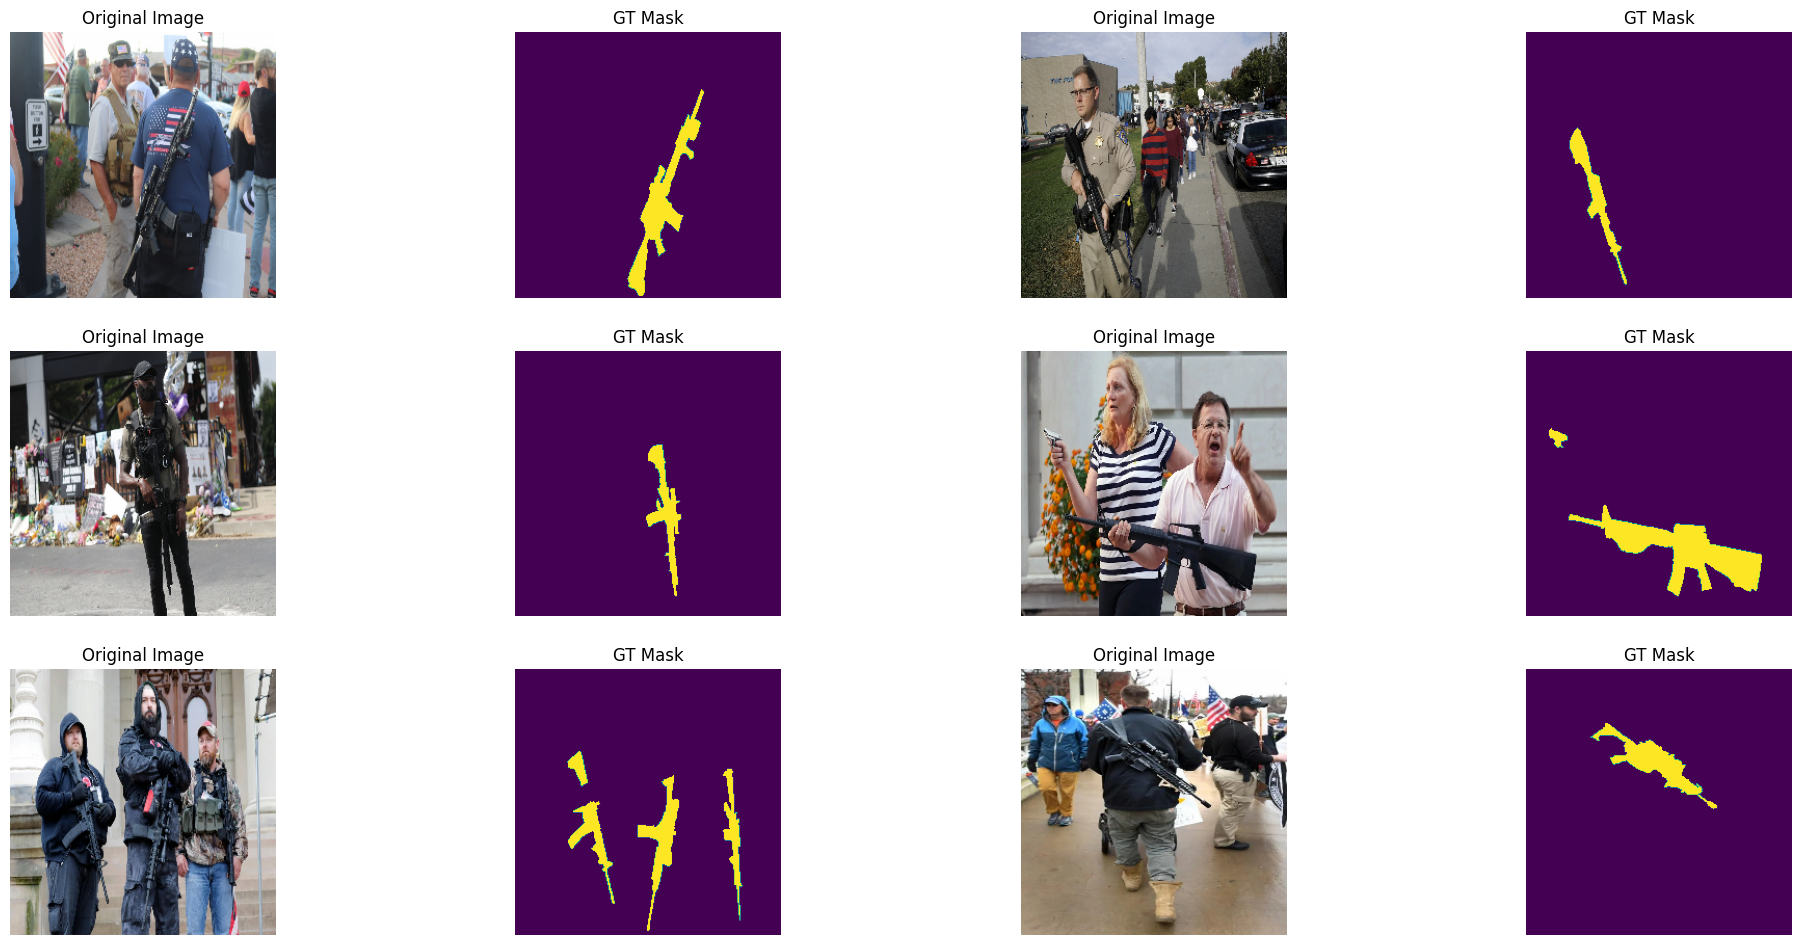

In [37]:
visualize_dataset(tr_dl.dataset, num_images=20)

## Define inference function

In [33]:
def inference(dl, model, device, n_ims=15):
    cols = n_ims // 3
    rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        images, masks = data
        im = images[0].unsqueeze(0)
        gt = masks[0].unsqueeze(0)
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        ims.append(im)
        gts.append(gt)
        preds.append(pred)

    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols:
            break

        # First plot
        count = plot_image(cols, rows, count, im)

        # Second plot
        count = plot_image(cols, rows, count, gt.squeeze(0), mask=None, title="Ground Truth")

        # Third plot
        count = plot_image(cols, rows, count, pred, mask=None, title="Predicted Mask")


## Load the best model and performing inference

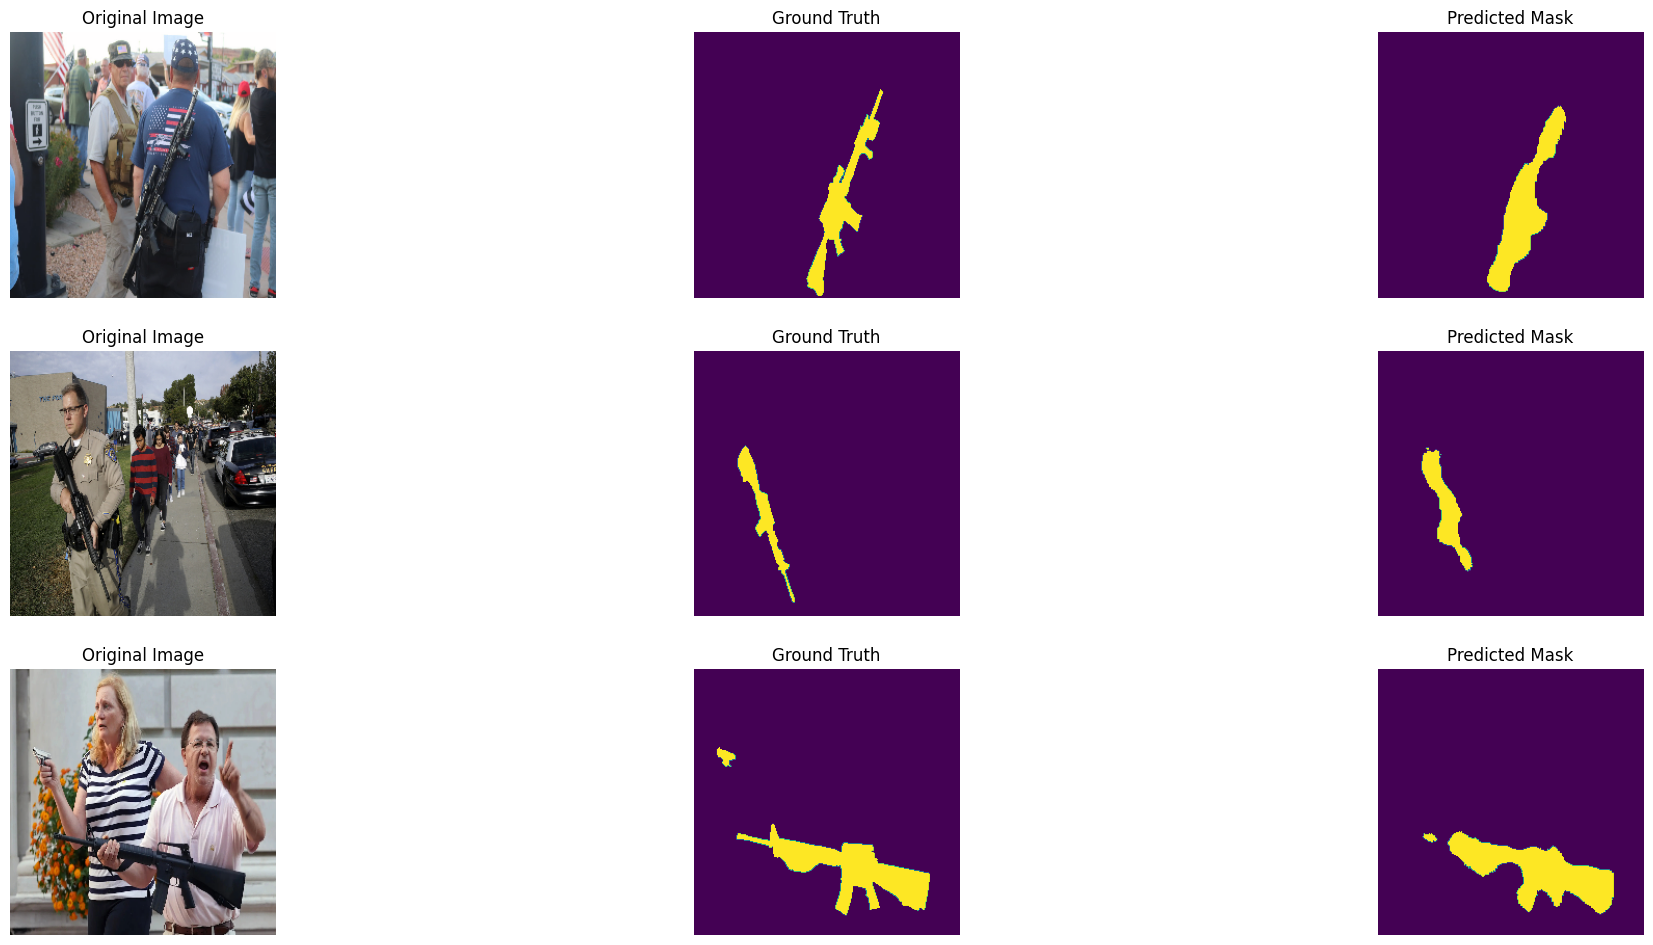

In [34]:
model = torch.load("saved_models/guns_best_model.pt")
inference(tr_dl, model=model, device=device)